In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


In [ ]:
# Verifica se o TensorFlow está usando GPU
print("TensorFlow version:", tf.__version__)
print("GPU disponível:", tf.config.list_physical_devices('GPU'))


TensorFlow version: 2.18.0
GPU disponível: []


In [ ]:
#Carregar dataset cats_vs_dogs do TensorFlow DS
(train_ds, val_ds), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

class_names = ds_info.features['label'].names
print("Classes:", class_names)



Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.UIUR80_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.
Classes: ['cat', 'dog']


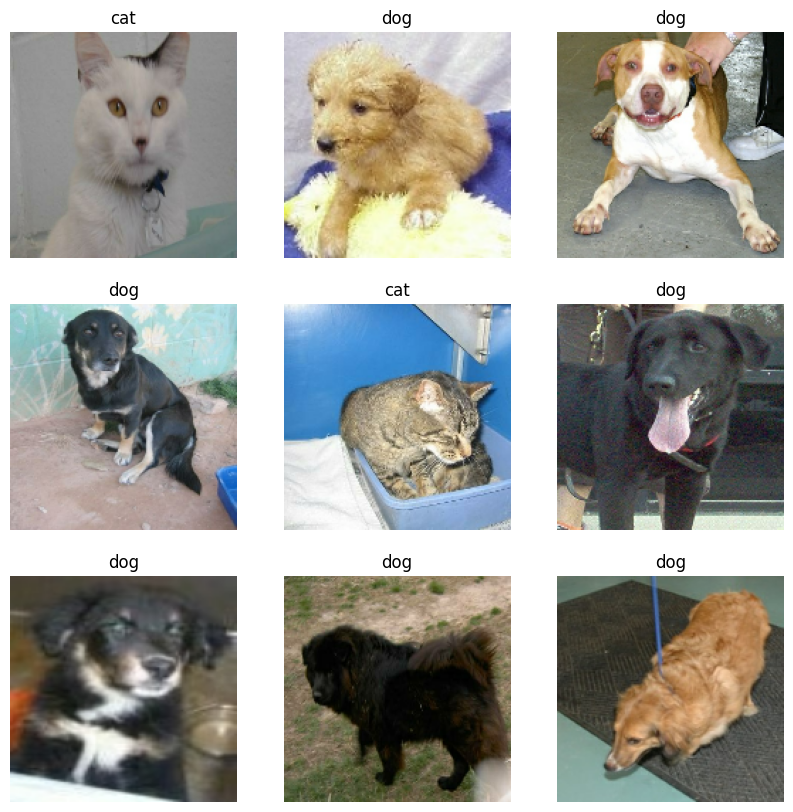

In [ ]:
#Pré-processamento: redimensionar, normalizar e criar batches
IMG_SIZE = (160, 160)
BATCH_SIZE = 32

def format_image(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = image / 255.0  # normalização
    return image, label

train_batches = (
    train_ds
    .shuffle(1000)
    .map(format_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

val_batches = (
    val_ds
    .map(format_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

# Pegamos um batch do dataset e mostramos 9 imagens
for image_batch, label_batch in train_batches.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow((image_batch[i].numpy() * 255).astype("uint8"))
        plt.title(class_names[label_batch[i].numpy()])
        plt.axis("off")


In [ ]:
#Carregar o modelo base pré-treinado (MobileNetV2)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # congelar as camadas


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
#Criar o modelo com a cabeça de classificação
model = Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1)  # Saída binária (gato ou cachorro)
])


In [ ]:
#Compilar o modelo
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)


In [ ]:
#Treinar o modelo
EPOCHS = 5
history = model.fit(
    train_batches,
    validation_data=val_batches,
    epochs=EPOCHS
)


Epoch 1/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 277s 469ms/step - accuracy: 0.9277 - loss: 0.1586 - val_accuracy: 0.9794 - val_loss: 0.0606
Epoch 2/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 286s 491ms/step - accuracy: 0.9794 - loss: 0.0576 - val_accuracy: 0.9809 - val_loss: 0.0556
Epoch 3/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 336s 515ms/step - accuracy: 0.9813 - loss: 0.0522 - val_accuracy: 0.9798 - val_loss: 0.0547
Epoch 4/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 304s 485ms/step - accuracy: 0.9823 - loss: 0.0465 - val_accuracy: 0.9768 - val_loss: 0.0568
Epoch 5/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 315s 472ms/step - accuracy: 0.9844 - loss: 0.0448 - val_accuracy: 0.9800 - val_loss: 0.0554


In [ ]:
#Avaliar o modelo
loss, accuracy = model.evaluate(val_batches)
print(f"Acurácia: {accuracy*100:.2f}%")


146/146 ━━━━━━━━━━━━━━━━━━━━ 56s 383ms/step - accuracy: 0.9835 - loss: 0.0477
Acurácia: 98.00%


In [ ]:
#Testar com imagem nova (upload manual)
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
    path = fn

img = tf.keras.preprocessing.image.load_img(path, target_size=IMG_SIZE)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) / 255.0  # normalização

predictions = model.predict(img_array)
score = tf.nn.sigmoid(predictions[0])
score_value = score.numpy().item()  # extrai escalar

print(f"Confiança de que é cachorro: {score_value*100:.2f}%")

if score_value > 0.5:
    print("→ Predição: 🐶")
else:
    print("→ Predição: 🐱")


Saving cachorro-mini-pet-1280x720.jpg to cachorro-mini-pet-1280x720 (3).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Confiança de que é cachorro: 90.97%
→ Predição: 🐶
